# ROMY & FUR

## Load Libraries

In [2]:
import os, sys
import pickle
import matplotlib.pyplot as plt
import numpy as np

from obspy import UTCDateTime, read_inventory
from scipy.signal import welch
from pandas import read_pickle

from functions.get_time_intervals import __get_time_intervals


In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [4]:
from functions.get_time_intervals import __get_time_intervals

In [18]:
config = {}

config['tbeg'] = UTCDateTime("2023-09-21")
config['tend'] = UTCDateTime("2023-09-30")

# config['tbeg'] = UTCDateTime("2023-12-01")
# config['tend'] = UTCDateTime("2023-12-11")

config['path'] = data_path+"VelocityChanges/data/"


In [19]:
dates = __get_time_intervals(config['tbeg'], config['tend'], interval_seconds=86400, interval_overlap=0)


baz1, baz2, baz3 = np.array([]), np.array([]), np.array([])
std1, std2, std3 = np.array([]), np.array([]), np.array([])
ttt = np.array([])

for _n, (d1, d2) in enumerate(dates):
    print(d1)
    filename = f"VC_BAZ_{d1.date}_{d2.date}.pkl"

    if os.path.isfile(config['path']+filename):
        out = read_pickle(config['path']+filename)

    baz1 = np.append(baz1, out['baz_tangent'])
    baz2 = np.append(baz2, out['baz_rayleigh'])
    baz3 = np.append(baz3, out['baz_love'])

    std1 = np.append(std1, out['baz_tangent_std'])
    std2 = np.append(std2, out['baz_rayleigh_std'])
    std3 = np.append(std3, out['baz_love_std'])

    ttt = np.append(ttt, out['time'])

2023-09-21T00:00:00.000000Z
2023-09-22T00:00:00.000000Z
2023-09-23T00:00:00.000000Z
2023-09-24T00:00:00.000000Z
2023-09-25T00:00:00.000000Z
2023-09-26T00:00:00.000000Z
2023-09-27T00:00:00.000000Z
2023-09-28T00:00:00.000000Z
2023-09-29T00:00:00.000000Z


In [147]:
std1 = np.array([1 if s < 1 else s for s in std1])
std2 = np.array([1 if s < 1 else s for s in std2])
std3 = np.array([1 if s < 1 else s for s in std3])


## Plotting

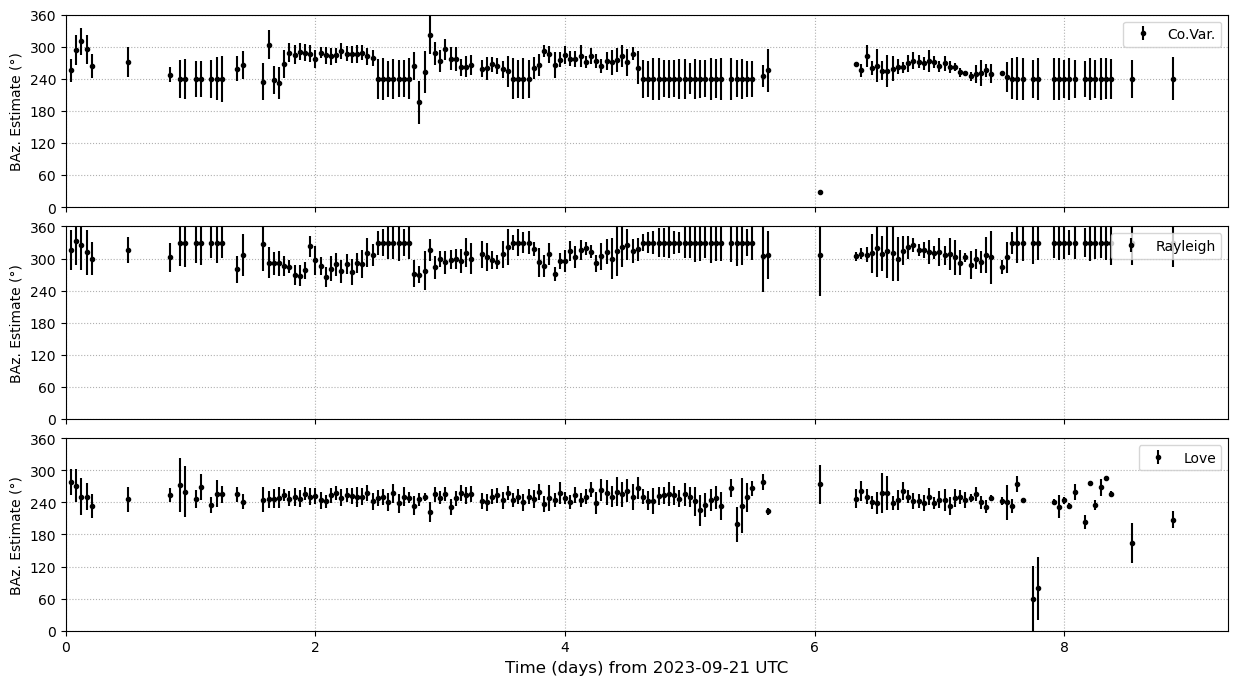

In [148]:
def __makeplot():

    Nrow, Ncol = 3, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    t_axis = (ttt-ttt[0])/86400

    ax[0].errorbar(t_axis, baz1, yerr=std1/2, fmt="k.", label="Co.Var.")
    ax[1].errorbar(t_axis, baz2, yerr=std2/2, fmt="k.", label="Rayleigh")
    ax[2].errorbar(t_axis, baz3, yerr=std3/2, fmt="k.", label="Love")

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)
        ax[_n].set_ylim(0, 360)
        ax[_n].set_yticks(np.arange(0, 360+60, 60))
        ax[_n].set_ylabel("BAz. Estimate (°)")
        ax[_n].set_xlim(left=0)

    ax[Nrow-1].set_xlabel(f"Time (days) from {config['tbeg'].date} UTC", fontsize=font)

    plt.show();
    return fig

fig = __makeplot();

In [149]:
def circular_hist(ax, x, nbins=72, density=True, offset=0, gaps=True, weights=None):
    """
    Produce a circular histogram of angles on ax.

    Parameters
    ----------
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        axis instance created with subplot_kw=dict(projection='polar').

    x : array
        Angles to plot, expected in units of radians.

    bins : int, optional
        Defines the number of equal-width bins in the range. The default is 16.

    density : bool, optional
        If True plot frequency proportional to area. If False plot frequency
        proportional to radius. The default is True.

    offset : float, optional
        Sets the offset for the location of the 0 direction in units of
        radians. The default is 0.

    gaps : bool, optional
        Whether to allow gaps between bins. When gaps = False the bins are
        forced to partition the entire [-pi, pi] range. The default is True.

    Returns
    -------
    n : array or list of arrays
        The number of values in each bin.

    bins : array
        The edges of the bins.

    patches : `.BarContainer` or list of a single `.Polygon`
        Container of individual artists used to create the histogram
        or list of such containers if there are multiple input datasets.
    """
    # Wrap angles to [-pi, pi)
    x = (x+np.pi) % (2*np.pi) - np.pi

    # Force bins to partition entire circle
    if not gaps:
        nbins = np.linspace(-np.pi, np.pi, num=nbins+1)

    # Bin data and record counts
    if weights is not None:
        n, bins = np.histogram(x, bins=nbins, range=(-np.pi, np.pi), weights=weights)
    else:
        n, bins = np.histogram(x, bins=nbins, range=(-np.pi, np.pi))

    # Compute width of each bin
    widths = np.diff(bins)

    # By default plot frequency proportional to area
    if density:
        # Area to assign each bin
        area = n / x.size
        # Calculate corresponding bin radius
        radius = (area/np.pi) ** .5
    # Otherwise plot frequency proportional to radius
    else:
        radius = n

    # Plot data on ax
    patches = ax.bar(bins[:-1], radius, zorder=2, align='edge', width=widths,
                     edgecolor='darkred', fill=False, linewidth=0.7)

    # Set the direction of the zero angle
    # ax.set_theta_offset(offset)
    ax.set_theta_zero_location("N")  # theta=0 at the top

    ax.set_theta_direction(-1)  # theta increasing clockwise

    ax.grid(zorder=0)

    # Remove ylabels for area plots (they are mostly obstructive)
    if density:
        ax.set_yticks([])

    return n, bins, patches

In [ ]:
def __makeplot_polar():

    import matplotlib.pyplot as plt
    import numpy as np

    font = 12

    weight = True

    # Construct figure and axis to plot on
    fig, ax = plt.subplots(2, 2, subplot_kw=dict(projection='polar'), figsize=(8, 8))


    if weight:
        circular_hist(ax[0,0], np.deg2rad(baz1), weights=1/np.deg2rad(std1), density=True)
        circular_hist(ax[0,1], np.deg2rad(baz2), weights=1/np.deg2rad(std2), density=True)
        circular_hist(ax[1,0], np.deg2rad(baz3), weights=1/np.deg2rad(std3), density=True)
        circular_hist(ax[1,1], np.deg2rad(baz4), weights=1/np.deg2rad(std4), density=True)
    else:
        circular_hist(ax[0], np.deg2rad(baz1), density=False)
        circular_hist(ax[1], np.deg2rad(baz2), density=False)
        circular_hist(ax[1,0], np.deg2rad(baz3), density=False)
        circular_hist(ax[2], np.deg2rad(baz3), density=False)

    ax[0,0].set_title("(a) Co.Var.", loc="left")
    ax[0,1].set_title("(b) Beamforming", loc="left")
    ax[1,0].set_title("(c) Love", loc="left")
    ax[1,1].set_title("(d) Rayleigh", loc="left")

    for i in range(2):
        for j in range(2):
            ax[i,j].grid(color="k", zorder=0, ls="--", alpha=0.5)

    plt.suptitle(f"Backazimuth Estimation:  BW.ROMY - GR.FUR  ({t1} - {t2})", fontsize=font+1)

    plt.show();
    return fig

fig = __makeplot_polar()

### Plot on Map

NameError: name 'baz4' is not defined

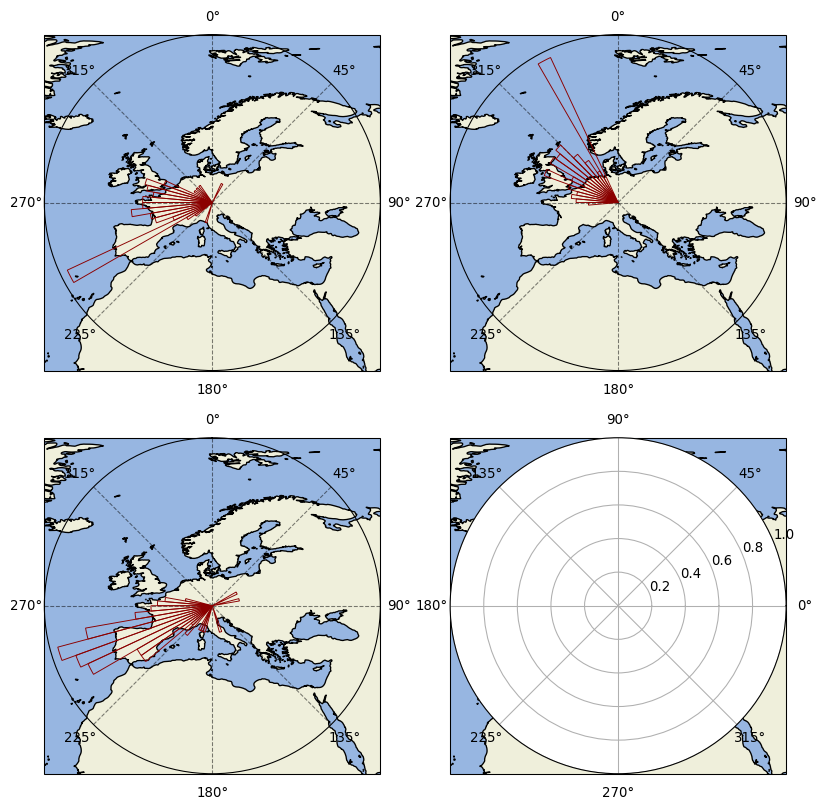

In [151]:
def __makeplot_maps():

    import gc
    import matplotlib.colors
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import matplotlib.pyplot as mpl
    import cartopy.feature as cfeature

    romy_lon = 11.275501
    romy_lat = 48.162941

    flatMap = ccrs.PlateCarree()

    resolution = '50m'


    fig = plt.figure(figsize=(10, 10), dpi=96)

    fig.subplots_adjust(hspace=0.2, wspace=0.2)

    ## ________________________________________________
    ax0 = fig.add_subplot(221, projection=flatMap)

    ax0.imshow(np.tile(np.array([[cfeature.COLORS['water'] * 255]], dtype=np.uint8), [2, 2, 1]),
              origin='upper',
              transform=ccrs.PlateCarree(),
              extent=[romy_lon-35, romy_lon+35, romy_lat-35, romy_lat+35]
             )

    ax0.add_feature(cfeature.NaturalEarthFeature('physical', 'land', resolution, edgecolor='black', facecolor=cfeature.COLORS['land']))

    ax00 = fig.add_subplot(221, projection='polar')

    # circular_hist(ax00, np.deg2rad(baz1), weights=1/np.deg2rad(std1), density=True)
    circular_hist(ax00, np.deg2rad(baz1), density=True)

    ax00.patch.set_alpha(0.)
    ax00.grid(color="k", ls="--", alpha=0.5)

    ax00.grid(color="k", zorder=0)


    ## ________________________________________________
    ax1 = fig.add_subplot(222, projection=flatMap)

    ax1.imshow(np.tile(np.array([[cfeature.COLORS['water'] * 255]], dtype=np.uint8), [2, 2, 1]),
              origin='upper',
              transform=ccrs.PlateCarree(),
              extent=[romy_lon-35, romy_lon+35, romy_lat-35, romy_lat+35]
             )

    ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', resolution, edgecolor='black', facecolor=cfeature.COLORS['land']))


    ax01 = fig.add_subplot(222, projection='polar')

    # circular_hist(ax01, np.deg2rad(baz2), weights=1/np.deg2rad(std2), density=True)
    circular_hist(ax01, np.deg2rad(baz2), density=True)

    ax01.patch.set_alpha(0.)
    ax01.grid(color="k", ls="--", alpha=0.5)

    ax01.grid(color="k", zorder=0)


    ## ________________________________________________
    ax2 = fig.add_subplot(223, projection=flatMap)

    ax2.imshow(np.tile(np.array([[cfeature.COLORS['water'] * 255]], dtype=np.uint8), [2, 2, 1]),
              origin='upper',
              transform=ccrs.PlateCarree(),
              extent=[romy_lon-35, romy_lon+35, romy_lat-35, romy_lat+35]
             )

    ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'land', resolution, edgecolor='black', facecolor=cfeature.COLORS['land']))

    ax02 = fig.add_subplot(223, projection='polar')

    # circular_hist(ax02, np.deg2rad(baz3), weights=1/np.deg2rad(std3), density=True)
    circular_hist(ax02, np.deg2rad(baz3), density=True)

    ax02.patch.set_alpha(0.)
    ax02.grid(color="k", ls="--", alpha=0.5)

    ax02.grid(color="k", zorder=0)


    ## ________________________________________________
    ax3 = fig.add_subplot(224, projection=flatMap)


    ax3.imshow(np.tile(np.array([[cfeature.COLORS['water'] * 255]], dtype=np.uint8), [2, 2, 1]),
              origin='upper',
              transform=ccrs.PlateCarree(),
              extent=[romy_lon-35, romy_lon+35, romy_lat-35, romy_lat+35]
             )

    ax3.add_feature(cfeature.NaturalEarthFeature('physical', 'land', resolution, edgecolor='black', facecolor=cfeature.COLORS['land']))

    ax03 = fig.add_subplot(224, projection='polar')

    # circular_hist(ax01, np.deg2rad(baz4), weights=1/np.deg2rad(std4), density=True)
    circular_hist(ax03, np.deg2rad(baz4), density=True)

    ax03.patch.set_alpha(0.)
    ax03.grid(color="k", ls="--", alpha=0.5)

    ax03.grid(color="k", zorder=0)



    gc.collect()

    plt.show();
    return fig


fig = __makeplot_maps()

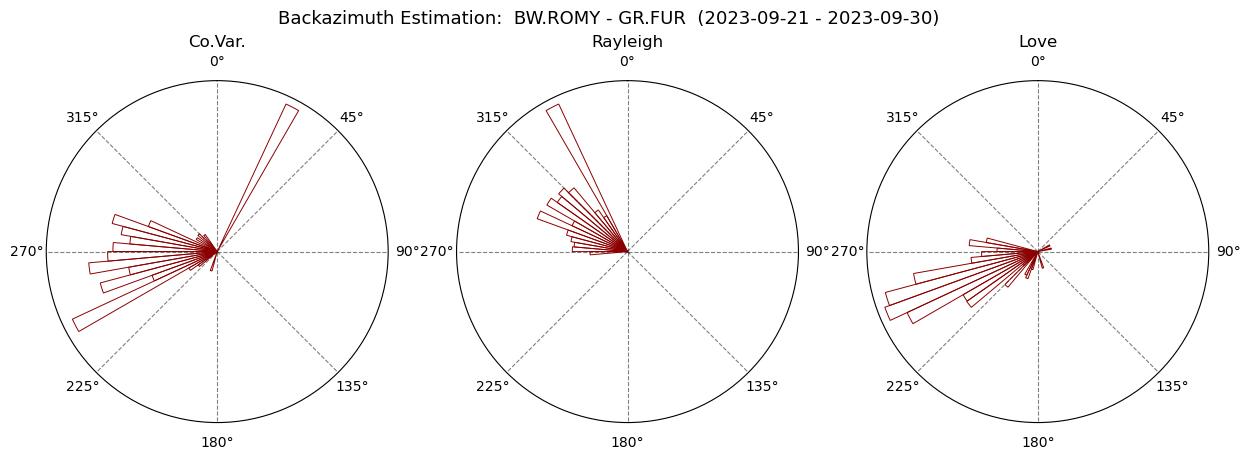

In [150]:
# import matplotlib.pyplot as plt
# import numpy as np

# font = 12

# # Construct figure and axis to plot on
# fig, ax = plt.subplots(1, 3, subplot_kw=dict(projection='polar'), figsize=(15, 5))

# circular_hist(ax[0], np.deg2rad(baz1), weights=1/np.deg2rad(std1), density=True)
# # circular_hist(ax[0], np.deg2rad(baz1), density=True)
# ax[0].set_title("Co.Var.")

# circular_hist(ax[1], np.deg2rad(baz2), weights=1/np.deg2rad(std2), density=True)
# # circular_hist(ax[1], np.deg2rad(baz2), density=True)
# ax[1].set_title("Rayleigh")

# circular_hist(ax[2], np.deg2rad(baz3), weights=1/np.deg2rad(std3), density=True)
# # circular_hist(ax[2], np.deg2rad(baz3), density=True)

# ax[2].set_title("Love")

# for _i in range(3):
#     ax[_i].grid(color="k", alpha=0.5, ls="--", zorder=0)

# plt.suptitle(f"Backazimuth Estimation:  BW.ROMY - GR.FUR  ({config['tbeg'].date} - {config['tend'].date})", fontsize=font+1)

# plt.show();

In [125]:
# import gc
# import matplotlib.colors
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
# import matplotlib.pyplot as mpl
# import cartopy.feature as cfeature

# romy_lon = 11.275501
# romy_lat = 48.162941

# flatMap = ccrs.PlateCarree()
# resolution = '50m'

# fig = plt.figure(figsize=(12, 6), dpi=96)

# ax = fig.add_subplot(111, projection=flatMap)

# ax.imshow(np.tile(np.array([[cfeature.COLORS['water'] * 255]], dtype=np.uint8), [2, 2, 1]),
#           origin='upper',
#           transform=ccrs.PlateCarree(),
#           extent=[romy_lon-35, romy_lon+35, romy_lat-35, romy_lat+35]
#          )

# ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', resolution, edgecolor='black', facecolor=cfeature.COLORS['land']))

# ax1 = fig.add_subplot(111, projection='polar', )

# # circular_hist(ax1, np.deg2rad(baz1), weights=1/np.deg2rad(std1), density=True)
# circular_hist(ax1, np.deg2rad(baz1), density=True)

# # ax1.set_title("Co.Var.")

# # ax1.get_xaxis().set_visible(False)
# # ax1.get_yaxis().set_visible(False)
# ax1.patch.set_alpha(0.)
# # ax1.axis("off")

# ax1.grid(color="k", zorder=0)

# gc.collect()

# plt.show();